# План

1. Подготовка данных  
    1.1 Загрузка данных  
    1.2 Описание данных  
    1.3 Предобработка данных  
    1.4 Короткий анализ данных  
    1.5 Подготовка данных для обучения  
    1.6 Вывод  
2. Обучение моделей  
    2.1 Catboost  
    2.2 LightGBM  
    2.3 LinearRegression  
3. Анализ моделей  
4. Вывод  

# Определение стоимости автомобилей

**Задача:**  
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

**Заказчику важны:**  
- качество предсказания;
- скорость предсказания;
- время обучения.

**Примечания:**  
Для оценки качества моделей применим метрику RMSE. Значение метрики RMSE должно быть меньше 2500.  
Освоим библиотеку LightGBM и её средствами постром модели градиентного бустинга.

## Подготовка данных

### Загрузка данных

In [33]:
# импортируем требуемые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from catboost import Pool, cv
from tqdm import tqdm

pd.set_option('display.max_columns', None)

In [2]:
# загрузим данные
df = pd.read_csv('/datasets/autos.csv')
# выведем рандомные 3 строки
df.sample(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
241946,2016-03-15 21:37:39,999,sedan,1997,manual,75,NaN,150000,1,petrol,volkswagen,no,2016-03-15 00:00:00,0,26629,2016-03-17 19:45:37
204400,2016-03-20 22:48:22,5999,small,2006,manual,120,cooper,150000,12,petrol,mini,no,2016-03-20 00:00:00,0,33729,2016-03-27 13:46:11
20689,2016-03-15 07:59:03,2399,sedan,2004,manual,125,vectra,150000,6,gasoline,opel,no,2016-03-15 00:00:00,0,66687,2016-03-27 18:15:33


Названия столбцов имеют заглавные буквы, переименуем колонки для более удобной работы.

In [3]:
df.columns = df.columns.str.lower()
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

### Описание данных

**Признаки:**  
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `NotRepaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак:**
* `Price` — цена (евро)

Удалим на текущем этапе признаки, которые на наш взгляд точно не потребуются для обучения:

* `date_crawled` — дата скачивания анкеты из базы 
* `date_created` — дата создания анкеты 
* `number_of_pictures` — количество фотографий автомобиля
* `postalcode` — почтовый индекс владельца анкеты (пользователя) 
* `last_seen` — дата последней активности пользователя 

In [5]:
columns_drop = ['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']
df = df.drop(columns_drop, axis=1)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


### Предобработка данных

In [6]:
# проверим датасет на пропуски, выведем поля, где они есть
df.isna().mean()[df.isna().mean() > 0]

vehicle_type    0.105794
gearbox         0.055967
model           0.055606
fuel_type       0.092827
not_repaired    0.200791
dtype: float64

Есть значительные пропуски (доля свыше 0,05 или свыше 5%) в 5 признаках. Для обучения модели CatBoost это не является проблемой, но мы так же будем использовать другие модели, где такие пропуски приведут к неудовлетворительным результатам.
Все признаки с пропусками категориальные, удалять пропуски не будем заменим их на unknown.
Умышленно скорее всего не заполнено поле NotRepaired — была машина в ремонте или нет. В остальных полях скорее всего просто нет требования к обязательному заполнению, хотя эти признаки влияют на конечную стоимость авто.

In [7]:
# сделаем замену пропусков
columns_fillna = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired']
df[columns_fillna] = df[columns_fillna].fillna('unknown')

In [8]:
# удалим записи с пропусками
df = df.dropna()
df.isna().mean()

price                 0.0
vehicle_type          0.0
registration_year     0.0
gearbox               0.0
power                 0.0
model                 0.0
kilometer             0.0
registration_month    0.0
fuel_type             0.0
brand                 0.0
not_repaired          0.0
dtype: float64

In [9]:
# проверим на дубли наш датасет
print('Кол-во дублей', df.duplicated().sum())

Кол-во дублей 27543


После замены пропусков появилось очень много дублей, но их мы удалим, чтобы улучшить обучение моделей.

In [10]:
df = df.drop_duplicates().reset_index(drop=True)

### Короткий анализ данных

In [11]:
# выведем общие данные по численным значениям
df.describe()

,price,registration_year,power,kilometer,registration_month
count,326826.000000,326826.000000,326826.000000,326826.000000,326826.000000
mean,4403.747330,2004.230985,110.244705,128144.073605,5.696239
std,4518.209808,91.120018,195.886373,37947.663920,3.724122
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1000.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6350.000000,2008.000000,141.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


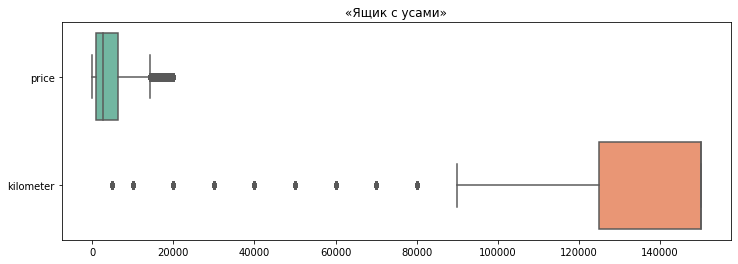

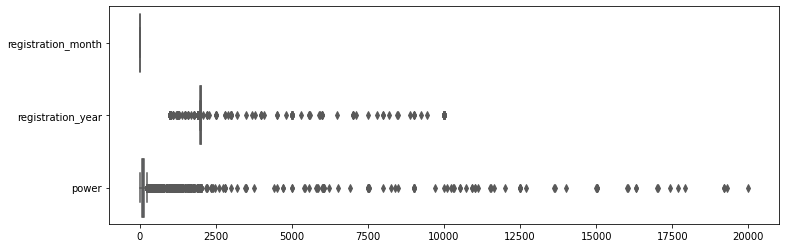

In [12]:
# посмотрим выбросы в числовых данных
column_plot = ['price', 'kilometer']
plt.figure(figsize=(12, 4))
sns.boxplot(data=df[column_plot], orient="h", palette="Set2")
plt.title(f'«Ящик с усами»')
plt.show();

column_plot = ['registration_month', 'registration_year', 'power']
plt.figure(figsize=(12, 4))
sns.boxplot(data=df[column_plot], orient="h", palette="Set2")
plt.show();

Имеем аномальные значения в поле price, где цена необъективно низкая или вовсе авная 0. Так же есть выбросы по мощности автомобилей (power) их мы удалим из датасета. В поле с годом регистрации есть аномальные значения (1000 и 9999), так же как и в поле месяц регистрации есть значения равные 0. Уберем выбросы и аномалии.

In [13]:
# уберем аномалии по цене, оставим данные свыше 100 евро
df = df.query('price > 100')
# уберем аномалии по году, оставим данные свыше 1900 года и меньше 2023
df = df.query('1900 <= registration_year < 2023')
# уберем выбросы по мощности, оставим данные меньше 1000 л.с.
df = df.query('power < 1000')

In [14]:
# колонку registration_month так же удалим из выборки для обучения 
df = df.drop('registration_month', axis=1)

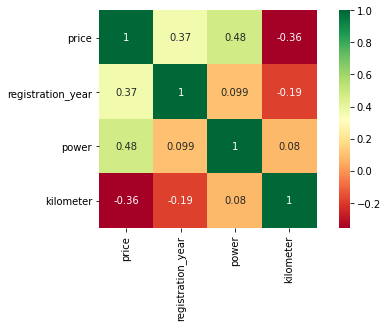

In [15]:
# выведем корреляцию Пирсона
plt.figure(figsize=(8, 4))
(sns.heatmap(
    df.corr()
    , annot=True
    , cmap='RdYlGn'
    , square=True)
)
plt.show()

Наблюдается небольшая корреляция к цене в зависимости от года постановки на учет, мощности и пробегу. У обучающих признаков корреляции между собой не наблюдается.

In [16]:
# проверим сколько данных осталось после удаления выбросов
df.shape[0]/354368

0.8851758623803504

### Подготовка данных для обучения

In [17]:
random_state = 777

In [18]:
# выделим целевой признак
# остальные признаки сохраним в отдельную выборку
# разобъем наши признаки на обучающие и тестовые 
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('price', axis=1), df.price, test_size=0.25, random_state=random_state)

In [19]:
# проверим полученные датасеты
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((235258, 9), (78420, 9), (235258,), (78420,))

### Вывод

Убрали признаки, которые не понадобятся для обучения:

* `date_crawled` — дата скачивания анкеты из базы 
* `date_created` — дата создания анкеты 
* `number_of_pictures` — количество фотографий автомобиля
* `postalcode` — почтовый индекс владельца анкеты (пользователя) 
* `last_seen` — дата последней активности пользователя * 
* `registration_month` — месяц регистрации автомобиля

На этапе подготовки данных для обучения были выявлены пропуски, дубликаты и аномалии.  
Пропуски замененили на unknown, т.к. они были в категориальных признаках.  
Дубли удалили для лучшего обучения модели.  
Выбросы и аномалии убрали из основной выборки.

## Обучение моделей

Catboost, LightGBM умеют работать с категориальными признаками, поэтому OHE применять не будем.
Сделаем OHE и стандартизацию при обучении моделей ансамбля.
Для оценки качества моделей применим метрику RMSE. 

In [20]:
# в данные списки будем записывать полученные метрики и модели
rmse = []
time_train = []
time_test = []
model_name = []

In [21]:
# подготовим список категориальных признаков
X_category = list(X_train.select_dtypes(include=['object']).columns)
X_category

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

### Catboost

Подберем параметры для CatBoost с помощью GridSearchCV. 

In [22]:
# укажем параметры 
parametrs = { 'iterations': range(40, 200, 40),
              'learning_rate': [0.25],
              'random_seed': [random_state],
              'l2_leaf_reg': [15],
              'depth': range(4, 16, 4)
            }

In [ ]:
# напишем функцию для расчета RMSE, котрую будем использовать в GridSearchCV.
def rmse(y, predict):
    rmse = mean_squared_error(y, predict) ** 0.5
    print(rmse)
    return rmse

In [23]:
%%time
start_time = time.time()

model_cbr = CatBoostRegressor()
grid = GridSearchCV(model_cbr, parametrs, cv=5)
grid.fit(X_train, y_train, cat_features=X_category, verbose=40)

end_time = time.time()
time_trn = end_time - start_time

0:	learn: 3930.6410083	total: 134ms	remaining: 5.23s
39:	learn: 1915.6429004	total: 2.36s	remaining: 0us
0:	learn: 3922.2862587	total: 68.9ms	remaining: 2.69s
39:	learn: 1920.0759388	total: 2.16s	remaining: 0us
0:	learn: 3921.5125516	total: 68ms	remaining: 2.65s
39:	learn: 1932.1080312	total: 2.18s	remaining: 0us
0:	learn: 3909.5404865	total: 89.5ms	remaining: 3.49s
39:	learn: 1927.7648199	total: 2.19s	remaining: 0us
0:	learn: 3925.9532670	total: 63.6ms	remaining: 2.48s
39:	learn: 1917.7486400	total: 2.13s	remaining: 0us
0:	learn: 3930.6410083	total: 64.2ms	remaining: 5.07s
50:	learn: 1882.6628876	total: 2.78s	remaining: 1.58s
79:	learn: 1825.3121264	total: 4.43s	remaining: 0us
0:	learn: 3922.2862587	total: 83.4ms	remaining: 6.59s
50:	learn: 1884.2314735	total: 2.8s	remaining: 1.59s
79:	learn: 1829.7165250	total: 4.31s	remaining: 0us
0:	learn: 3921.5125516	total: 65.9ms	remaining: 5.21s
50:	learn: 1891.0370244	total: 2.87s	remaining: 1.63s
79:	learn: 1832.5151582	total: 4.46s	remaining

In [66]:
# выведем лучшие параметры для нашей модели
grid.best_params_

{'depth': 12,
 'iterations': 160,
 'l2_leaf_reg': 15,
 'learning_rate': 0.25,
 'random_seed': 777}

In [67]:
%%time
# обучим нашу модель с лучшими параметрами, чтобы замерить время обучения
start_time = time.time()

model_cbr = CatBoostRegressor(depth=12, iterations=160, l2_leaf_reg=15, learning_rate=0.25, random_seed=777)
model_cbr.fit(X_train, y_train, cat_features=X_category, verbose=40, plot=True)

end_time = time.time()
time_trn = end_time - start_time

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3756.9099567	total: 249ms	remaining: 39.7s
40:	learn: 1668.9498242	total: 8.47s	remaining: 24.6s
80:	learn: 1584.2013079	total: 16.9s	remaining: 16.4s
120:	learn: 1537.1240831	total: 25.2s	remaining: 8.13s
159:	learn: 1503.0046726	total: 33.5s	remaining: 0us
CPU times: user 33.7 s, sys: 228 ms, total: 34 s
Wall time: 35.1 s


In [63]:
%%time
start_time = time.time()

predict_cbr = model_cbr.predict(X_test)
rmse_cbr = mean_squared_error(y_test, predict_cbr) ** 0.5

end_time = time.time()
time_tst = end_time - start_time

print('RMSE модели Catboost:', rmse_cbr)

RMSE модели Catboost: 1639.083256449135
CPU times: user 185 ms, sys: 0 ns, total: 185 ms
Wall time: 182 ms


In [43]:
rmse.append(rmse_cbr)
time_train.append(time_trn)
time_test.append(time_tst)
model_name.append(model_cbr.__class__.__name__)

Более 12 минут потратили на подбор параметров для модели. По итогу с лучшими параметрами достигли RMSE ниже 2500, модель обучалась 35s.

### LightGBM

In [44]:
# создадим список с признаками
futures_name = list(X_train.columns)
futures_name

['vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'fuel_type',
 'brand',
 'not_repaired']

In [45]:
X_train_lgb = X_train.copy()

In [46]:
%%time
start_time = time.time()

for c in X_category:
    X_train_lgb[c] = X_train_lgb[c].astype('category')

df_train_lgb = lgb.Dataset (X_train_lgb, label = y_train, feature_name = futures_name,
                           categorical_feature = X_category
                           )

param = {'learning_rate':0.1, 'n_estimators':1200, 'objective':'root_mean_squared_error'}

num_round = 1000
model_lgb = lgb.train(param, df_train_lgb, num_round)

end_time = time.time()
time_trn = end_time - start_time

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 235258, number of used features: 9
[LightGBM] [Info] Start training from score 4582.794987
CPU times: user 43.3 s, sys: 180 ms, total: 43.5 s
Wall time: 44 s


In [47]:
X_test_lgb = X_test.copy()

In [48]:
%%time
start_time = time.time()
for c in X_category:
    X_test_lgb[c] = X_test_lgb[c].astype('category')

predict_lgb = model_lgb.predict(X_test_lgb)
rmse_lgb = mean_squared_error(y_test, predict_lgb) ** 0.5

end_time = time.time()
time_tst = end_time - start_time
print('RMSE модели LGBM', rmse_lgb)

RMSE модели LGBM 1590.6366395051475
CPU times: user 11.9 s, sys: 25.1 ms, total: 11.9 s
Wall time: 11.9 s


In [49]:
rmse.append(rmse_lgb)
time_train.append(time_trn)
time_test.append(time_tst)
model_name.append('LightGBM')

LightGBM показывает результаты по метрике RMSE и времени обучения лучше, чем CatBoost.

### LinearRegression

In [50]:
# преобразуем категориальные признаки в численные с помощью техники прямого кодирования
# датасет будем снова разбивать на обучающую и тестовую выборки, иначе технология OHE не сработает на уже полученных выборках
df_lnr = pd.get_dummies(df, drop_first=True)
# выделим целевой признак
# остальные признаки сохраним в отдельную выборку
# разобъем наши признаки на обучающие и тестовые 
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    df_lnr.drop('price', axis=1), df_lnr.price, test_size=0.25, random_state=random_state)

In [51]:
%%time
start_time = time.time()

model_lnr = LinearRegression()
model_lnr.fit(X_train_2, y_train_2)

end_time = time.time()
time_trn = end_time - start_time

CPU times: user 16.7 s, sys: 5.53 s, total: 22.2 s
Wall time: 22.4 s


In [52]:
%%time
start_time = time.time()

predict_lnr = model_lnr.predict(X_test_2)
rmse_lnr = mean_squared_error(y_test_2, predict_lnr) ** 0.5

end_time = time.time()
time_tst = end_time - start_time

print('RMSE модели LinearRegression:', rmse_lnr)

RMSE модели LinearRegression: 2726.6225919819253
CPU times: user 127 ms, sys: 207 ms, total: 334 ms
Wall time: 296 ms


In [53]:
rmse.append(rmse_lnr)
time_train.append(time_trn)
time_test.append(time_tst)
model_name.append('LinearRegression')

LinearRegression показывает результаты по метрике RMSE хуже пороговых 2500.

## Анализ моделей

По каждой модели мы сохранили три метрики, преобразуем наши списки в датафрейм.

In [62]:
stat = pd.DataFrame({'model_name': model_name, 'time_train, sec': time_train,
      'time_test, sec': time_test , 'rmse': rmse}
    ).sort_values(by='rmse').reset_index(drop=True)
stat['total_time'] = stat['time_test, sec'] + stat['time_train, sec']
# выделим лучшие значения
(
    stat.style.highlight_min(['rmse', 'time_train, sec', 'time_test, sec', 'total_time'], color='green', axis = 0)
)

,model_name,"time_train, sec","time_test, sec",rmse,total_time
0,LightGBM,43.988050,11.863910,1590.636640,55.851959
1,CatBoostRegressor,35.265799,0.164829,1639.083256,35.430628
2,LinearRegression,22.377592,0.294725,2726.622592,22.672318


Самые лучшие результаты по скорости обучения и предсказаний у модели LinearRegression, но с самым худшим RMSE.
RMSE лучше у LightGBM и по времени данная модель занимает 3 место.
CatBoostRegressor после подбора параметров обучается быстрее LightGBM, показатель RMSE на 3% хуже, чем у LightGBM.

Проверим важность признаков на двух моделях CatBoostRegressor и LightGBM.

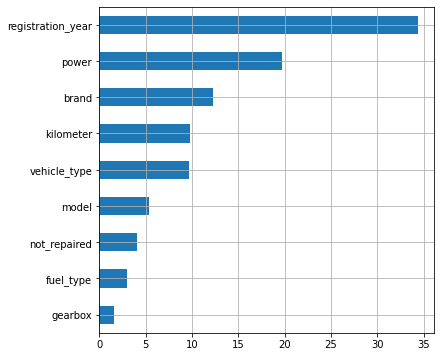

In [55]:
# важность признаков CatBoostRegressor
(pd.DataFrame(data={'score': model_cbr.feature_importances_}, 
                      index=X_train.columns).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False))
plt.show;

Для модели CatBoostRegressor самым важным признаком оказался год регистрации, далее в рейтинге мощность авто и марка авто.

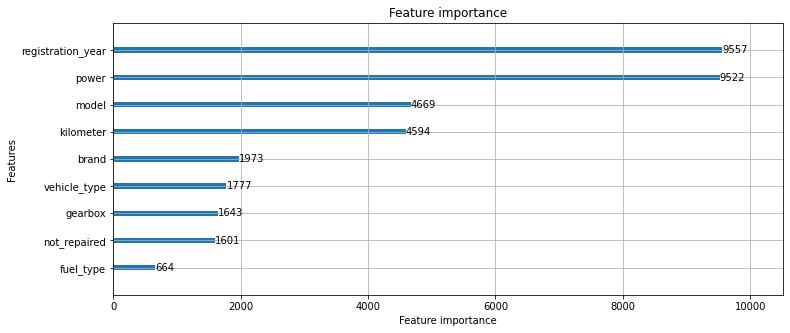

In [56]:
# важность признаков LightGBM
lgb.plot_importance(model_lgb, figsize = (12, 5))
plt.show()

Для модели LightGBM самыми важными признаками являются так же год регистрации и мощность авто, причем эти два признака для модели примерно одинаковы по важности.

Таким образом для обеих моделей имеем два важных признака, возможно стоит попробовать категоризовать поля registration_year и power, т.е. исходя из диапозонов дать им категории и первоначальные признаки удалить, перед обучением модели.  

Исходя из всех параметров и выбирая баланс, я бы рекомендовала CatBoostRegressor, по скорости он быстрее, а в качестве теряет 3%.

## Вывод

В задаче были важны три показателя качество предсказания, время обучения, скорость предсказания.  

Самое высокое качество дала модель LightGBM (RMSE = 1590,6), время обучения 44 сек., предсказания 12 сек..
Самые высокие скорости обучения и предсказания дала модель линейной регрессии, но ее качество превысило отметку 2500.
Важно учитывать совокупность факторов и для поставленной задачи подходит модель CatBoostRegressor, по скорости он быстрее LightGBM, а в качестве теряет 3%.
У модели LightGBM самыми важными признаками являются год регистрации и мощность авто. Возможно стоит попробовать категоризовать поля registration_year и power, т.е. исходя из диапозонов значений дать им категории и первоначальные признаки удалить, перед обучением модели.

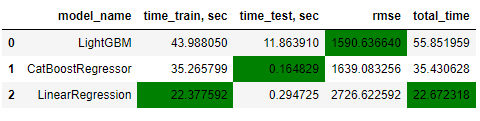